# SVM

### Import libraries

In [1]:
import pandas as pd # one-hot encoding
import numpy as np
import glob
import os

import matplotlib.pyplot as plt # graphs
import matplotlib.colors as colors

from collections import defaultdict

import pickle
import sklearn
from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV # cross validation
#from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # support vector classifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

### Import data

We work with 1956 comments from 5 different YouTube videos. The [YouTube Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection#) is freely available.

In [2]:
path = r"data/YouTube-Spam-Collection/"
files = glob.glob(os.path.join(path, "*.csv"))

corpus = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
corpus.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [3]:
assert len(corpus) == 1956

### Peprocessing

In [4]:
#nltk.download('stopwords')
#nltk.download('omw-1.4')
    
def preprocess_data(corpus,
                    columns=["CONTENT"],
                    irrelevant_features=["COMMENT_ID", "AUTHOR", "DATE"],
                    #rename_colunms={"CONTENT":"COMMENT"}
                   ):

    #for column in columns:
        # remove blank rows if any
        #corpus[column].dropna(inplace=True)
        # lower case
        #corpus[column] = [entry.lower() for entry in corpus[column]]

    # drop irrelevant features
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # change column name
    #for old, new in rename_columns:
        #corpus.rename({old : new}, axis=1, inplace=True)

    cleaned_data = []
    lemma = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    for comment in corpus["CONTENT"]:    
        comment = nltk.word_tokenize(comment.lower()) # tokenizing
        comment = [lemma.lemmatize(word) for word in comment] # lemmatizing
        comment = [word for word in comment if word not in stop_words] # removing stopwords
        comment = " ".join(comment)
        cleaned_data.append(comment)
    
    return cleaned_data

In [5]:
cleaned_data = preprocess_data(corpus)
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleaned_data)

### Statistics about the data

In [6]:
print(f"Data types:\n{corpus.dtypes}\n")
print(f"There are {len(corpus['CLASS'].unique())} comment types: {corpus['CLASS'].unique()}")
print(f"The dataset contains of {len(corpus)} examples: {len(corpus.loc[corpus['CLASS'] == 1])} spam and {len(corpus.loc[corpus['CLASS'] == 0])} legitimate comments")

Data types:
CONTENT    object
CLASS       int64
dtype: object

There are 2 comment types: [1 0]
The dataset contains of 1956 examples: 1005 spam and 951 legitimate comments


### Split the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(BOW,
                                                     np.asarray(corpus["CLASS"]),
                                                     test_size=0.3, # default is 0.25
                                                     random_state=42,
                                                     #stratify=y,  # if imbalanced dataset
                                                     shuffle=True
                                                    )

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1369, 4194)
(587, 4194)
(1369,)
(587,)


### Support Vector Machine Classifier


Confusion matrix:


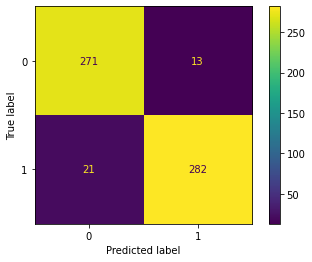


Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       284
           1       0.96      0.93      0.94       303

    accuracy                           0.94       587
   macro avg       0.94      0.94      0.94       587
weighted avg       0.94      0.94      0.94       587


Accuracy of the model: 94.20783645655877%


In [9]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train, y_train)
y_predict = clf_svm.predict(X_test)

print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_predict, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()
plt.show()

print("\nClassification report:")
print(classification_report(y_test, y_predict))

print("\nAccuracy of the model: {}%".format(accuracy_score(y_predict, y_test)*100))

### Train a SVM, saved the trained and SVM model and report the classification performance

In [10]:
def train_svm_classifer(features, # input features
                        labels, # labels associated with the features
                        model_output_path # for storing the trained model
                       ):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        labels,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        shuffle=True
                                                       )
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    param = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
             'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
            }
    
    # request probability estimation
    #svm = SVC(probability=True)
    
    # 10-fold cross validation
    clf = GridSearchCV(SVC(), param, cv=5, n_jobs=2, verbose=0)
    clf.fit(X_train, y_train)
    
    # save model to disk
    pickle.dump(clf.best_estimator_, open(model_output_path, 'wb+'))
    
    print("\nBest parameters set:")
    print(clf.best_params_)
    y_predict = clf.predict(X_test)
    
    labels = sorted(list(set(labels)))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_predict, labels=labels) # lables=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    
    print("\nAccuracy of the model: {}%".format(accuracy_score(y_predict, y_test)*100))

X_train shape: (1369, 4194)
X_test shape: (587, 4194)
y_train shape: (1369,)
y_test shape: (587,)

Best parameters set:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Confusion matrix:


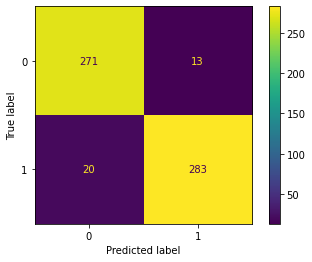


Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       284
           1       0.96      0.93      0.94       303

    accuracy                           0.94       587
   macro avg       0.94      0.94      0.94       587
weighted avg       0.94      0.94      0.94       587


Accuracy of the model: 94.37819420783646%


In [11]:
file_name = 'saved_models/svm_clf.sav'
train_svm_classifer(BOW, np.asarray(corpus["CLASS"]), file_name)

In [12]:
def load_saved_model(model_path):
    clf = pickle.load(open(model_path, 'rb'))
    print(clf)
    return clf

In [13]:
clf = load_saved_model(file_name)

SVC(C=100, gamma=0.01)
